# Tutorial 2.1
In this tutorial, we create a single metasurface imaging system and optimize it.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
from metabox import modeling, assembly
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the metamodel we created in tutorial 0.
metamodel = modeling.load_metamodel("TiO2_square_metamodel", './example_folder')
# Define the bounds of the feature.
metamodel.set_feature_constraint("width", vmin=10e-9, vmax=330e-9)

# Create a metasurface.
metasurface = assembly.Metasurface(
    diameter=100e-6,              # 100 microns in diameter
    refractive_index=1.0,         # the propagation medium after the metasurface
    thickness=300e-6,             # the distance to the next surface
    metamodel=metamodel,          # the metamodel to use
    enable_propagator_cache=True, # cache the propagators for faster computation
    set_structures_variable=True, # set the structures as a variable to optimize
)

# Define the incidence wavelengths and angles.
incidence = assembly.Incidence(
    wavelength=np.linspace(400e-9, 700e-9, 3),
    phi=[0],             # normal incidence
    theta=[0],           # normal incidence
)

# Create a lens assembly.
lens_assembly = assembly.LensAssembly(
        surfaces=[metasurface], # Define the array of surfaces. Here only one.
        incidence=incidence,   # Define the incidence.
        figure_of_merit=assembly.FigureOfMerit.LOG_STREHL_RATIO, # Define the figure of merit.
)

# Use the Adam optimizer to optimize the lens assembly. This rate should be
# empirically determined.
optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-8
)
optimizer.build(lens_assembly.get_variables())

# Optimize the lens assembly. Returns the best-optimized lens assembly and the loss history.
history = assembly.optimize_single_lens_assembly(
    lens_assembly, 
    optimizer, 
    n_iter=50,
    verbose=1,
    keep_best=True,
)

/home/huang/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loss: 0.645423: 100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


In [21]:
# At this point, you can save the optimized metasurface to a file.
lens_assembly.save("tutorial_2_lens_assembly", overwrite=True, save_dir="./example_folder")

# to export to GDSII, you can use the following
from metabox import export
export.generate_gds(metasurface, 0, "tutorial_2", "./example_folder")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


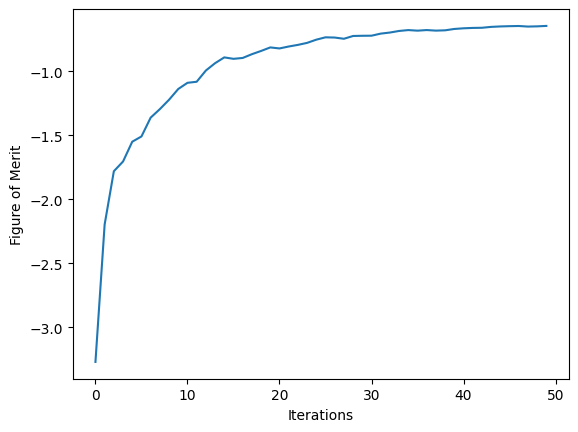

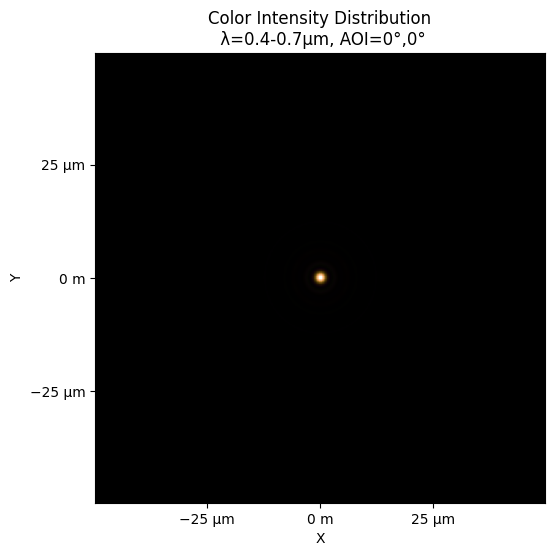

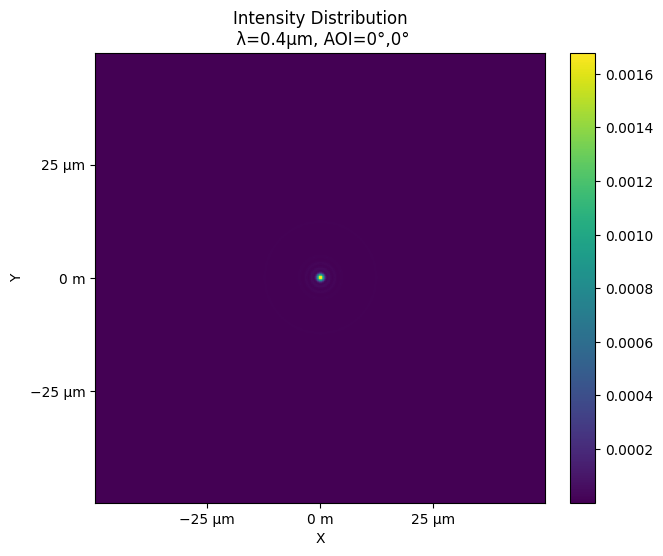

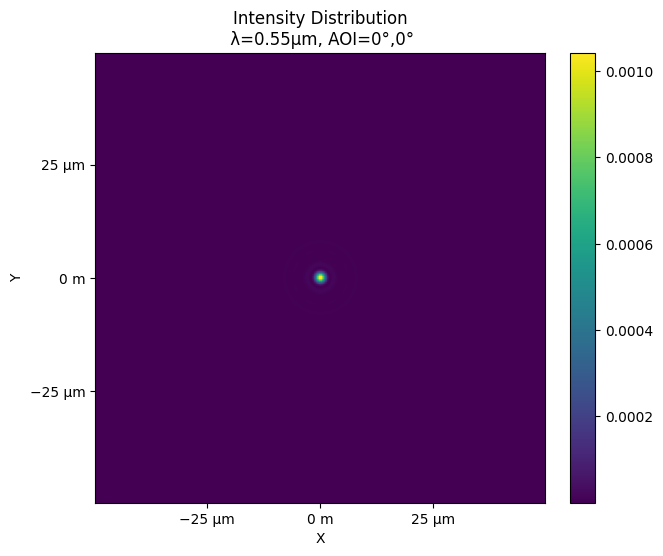

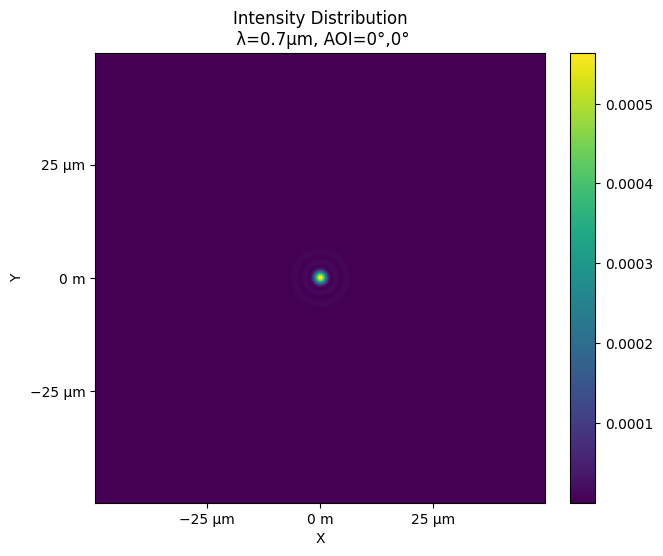

In [3]:
# Plot the history of the figure of merit.
plt.plot(history)
plt.xlabel("Iterations")
plt.ylabel("Figure of Merit")

# Compare the optimized and unoptimized fields.
lens_assembly.show_color_psf()
lens_assembly.show_psf()

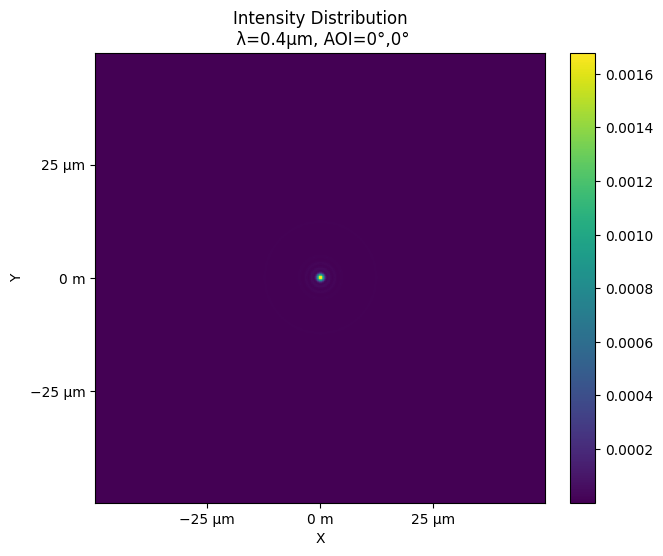

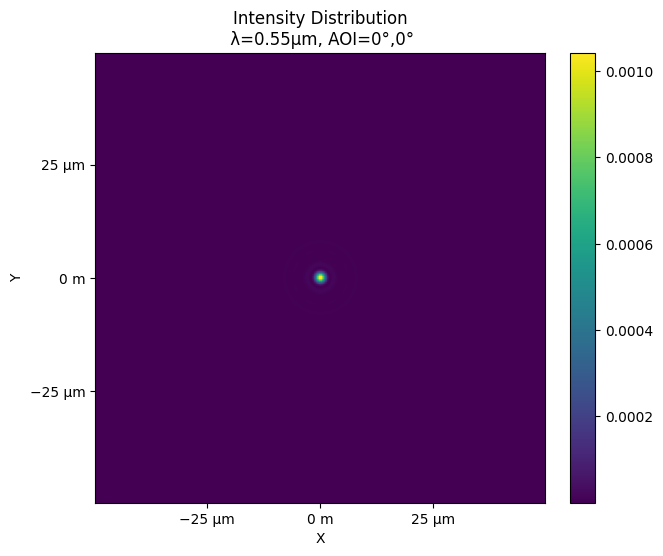

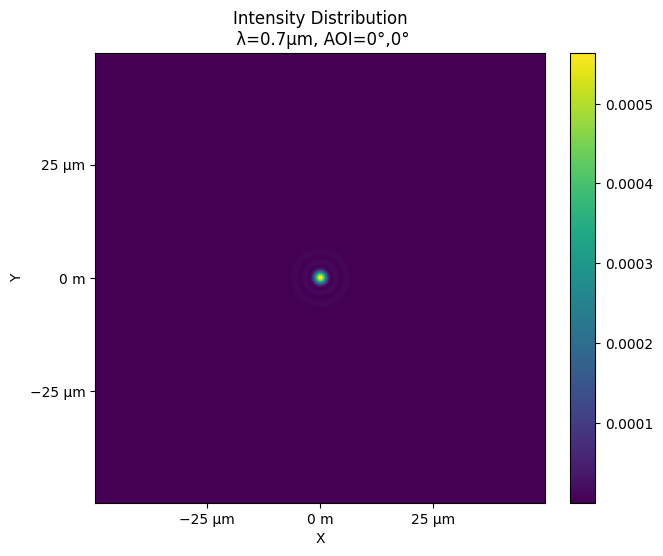

In [5]:
# For a new session, you can load the optimized metasurface from a file again.
from metabox import assembly

loaded_assembly = assembly.load_lens_assembly("tutorial_2_lens_assembly", "./example_folder")

# The PSFs should be the same.
loaded_assembly.show_psf()

# Here are some visualizaiton tools
To view the wavelength average PSF you can do

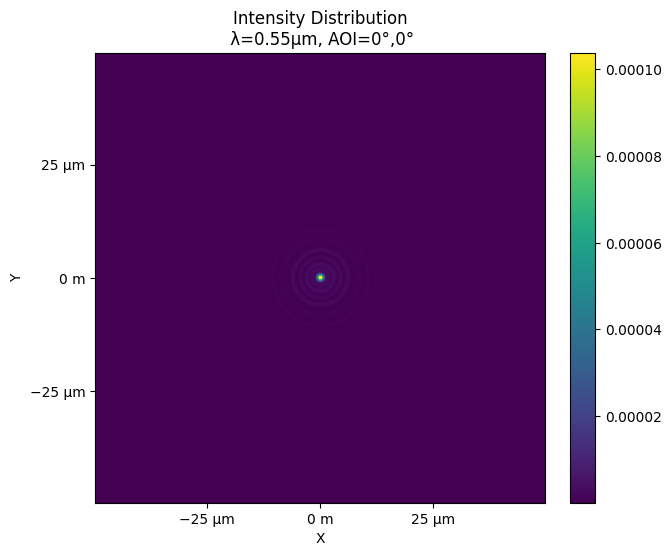

In [6]:
loaded_assembly.show_psf(use_wavelength_average=True)

If you are only interested in the center of the field, you can crop it

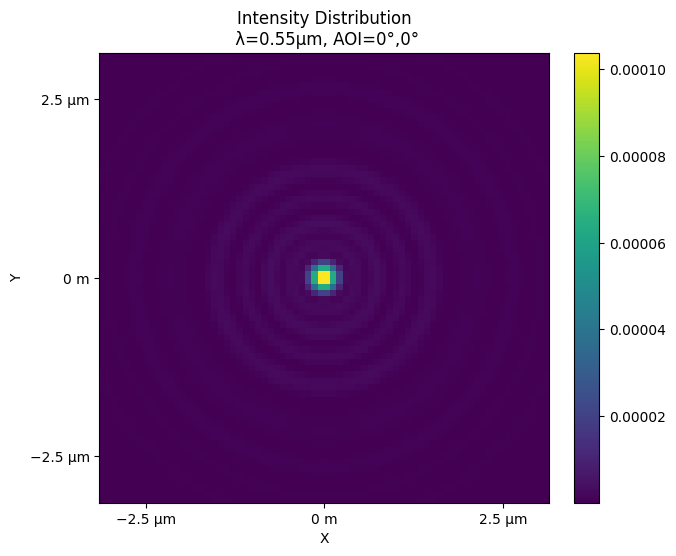

In [7]:
# At times it might be advantageous to crop the PSF to a smaller region.
loaded_assembly.show_psf(use_wavelength_average=True, crop_factor=0.25)

You can also display the intensity and phase modulation of the metasurface

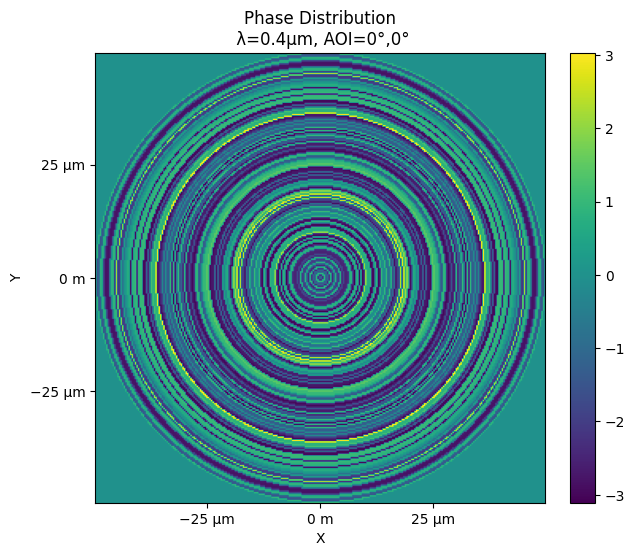

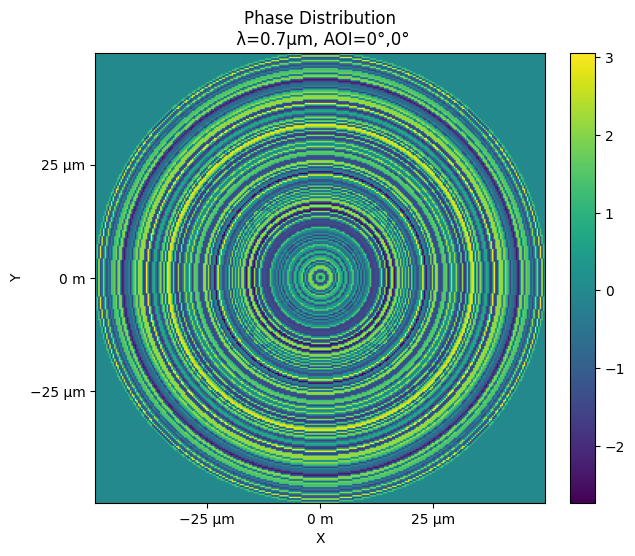

In [8]:
# You can access any surface in the assembly by calling the surfaces attribute.
# In this case, we only have one surface, so we can access it like so:
metasurface = loaded_assembly.surfaces[0]

# Now we can access field modulation given some incidence wavelengths and angles.
incidence = assembly.Incidence(
    wavelength=[400e-9, 700e-9],
    phi=[0],             # normal incidence
    theta=[0],           # normal incidence
)
modulation = metasurface.get_modulation_2d(incidence)

# Now let's plot the phase modulation of the metasurface.
modulation.show_phase()

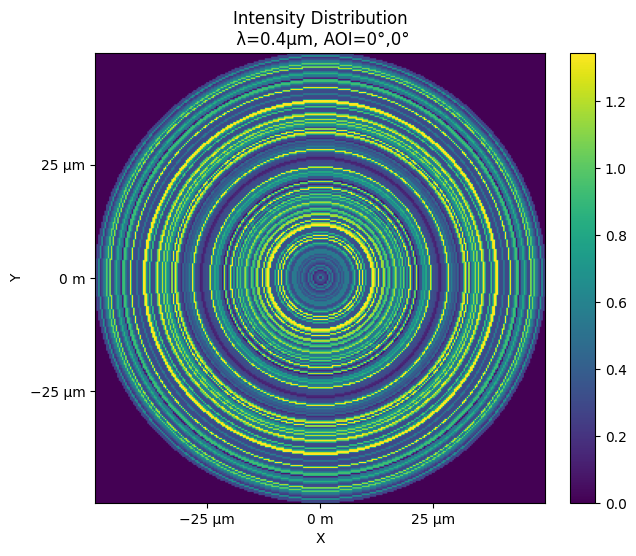

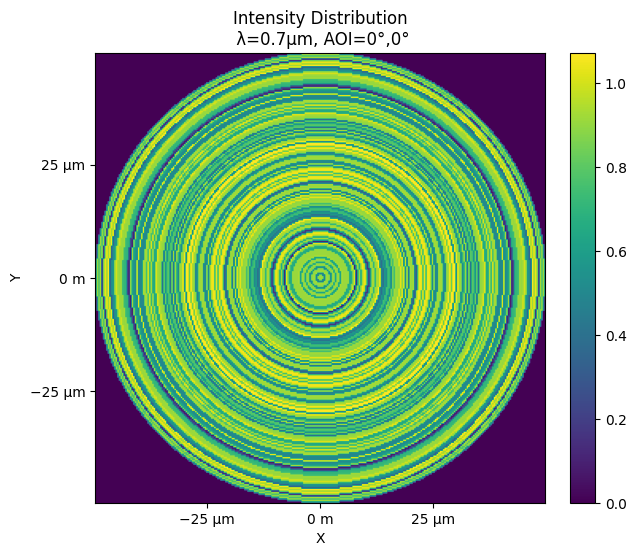

In [9]:
# We could also plot the intensity modulation of the metasurface.
modulation.show_intensity()

# 2.2 Optimization with ProtoUnitCell Directly (no metamodel)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from metabox import assembly, rcwa, utils
import tensorflow as tf

cell_period = 442e-9

radius = utils.Feature(vmin=0, vmax=221e-9, name="radius")
circle_1 = rcwa.Circle(2, radius=radius)
patterned_layer = rcwa.Layer(1, thickness=632e-9, shapes=[circle_1])
substrate = rcwa.Layer(1.5, thickness=632e-9)
cell = rcwa.UnitCell(
    layers=[patterned_layer, substrate], 
    periodicity=(cell_period, cell_period),
)
protocell = rcwa.ProtoUnitCell(cell)

# Create a metasurface.
metasurface = assembly.Metasurface(
    diameter=10e-6,              # 100 microns in diameter
    refractive_index=1.0,         # the propagation medium after the metasurface
    thickness=30e-6,             # the distance to the next surface
    proto_unit_cell=protocell,
    enable_propagator_cache=True, # cache the propagators for faster computation
    set_structures_variable=True, # set the structures as a variable to optimize
)

# Define the incidence wavelengths and angles.
incidence = assembly.Incidence(
    wavelength=np.linspace(400e-9, 700e-9, 1),
    phi=[0],             # normal incidence
    theta=[0],           # normal incidence
)

# Create a lens assembly.
lens_assembly = assembly.LensAssembly(
        surfaces=[metasurface], # Define the array of surfaces. Here only one.
        incidence=incidence,   # Define the incidence.
        figure_of_merit=assembly.FigureOfMerit.LOG_STREHL_RATIO, # Define the figure of merit.
        use_x_pol=True,        # Use the x-polarization.
)

# Use the Adam optimizer to optimize the lens assembly. This rate should be
# empirically determined.
optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-8
)
optimizer.build(lens_assembly.get_variables())

# Optimize the lens assembly. Returns the best-optimized lens assembly and the loss history.
history = assembly.optimize_single_lens_assembly(
    lens_assembly, 
    optimizer, 
    n_iter=20,
    verbose=1,
    keep_best=True,
)

Bar desc:   0%|          | 0/20 [00:00<?, ?it/s]

Basis file not found. Creating basis.


Loss: 0.476668: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


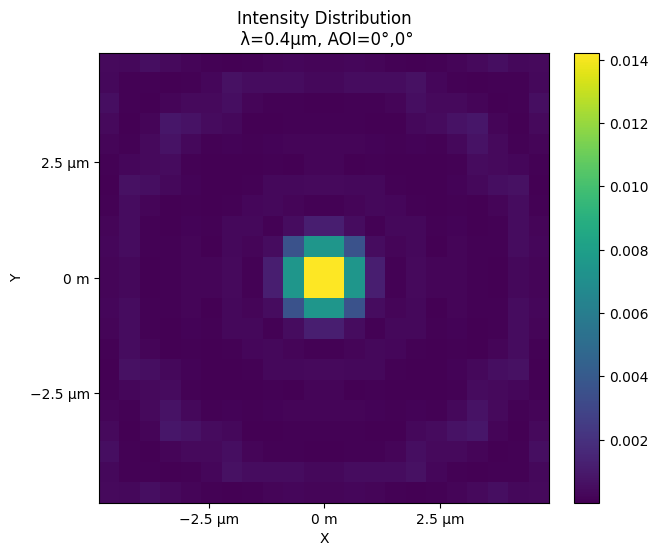

In [15]:
lens_assembly.show_psf()

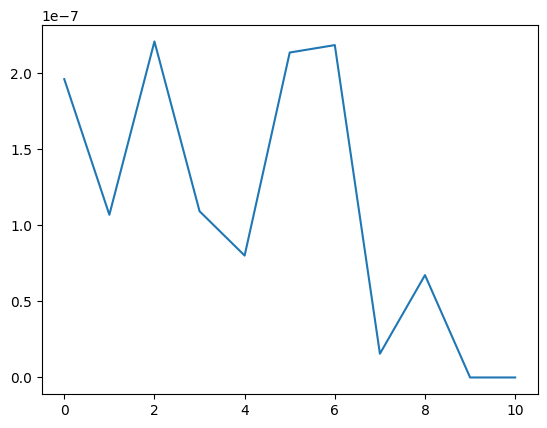

In [16]:
var = lens_assembly.get_variables()
radii = var[0].numpy()[0]
plt.plot(radii)